In [701]:
import numpy as np                        # базовые модули
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.stats as stats

import nltk                               # для обработки текстов 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

from datetime import datetime 

from PIL import Image                     # для облака слов
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler # для машинного обучения
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [172]:
def datetimer(string):                    # чтобы даты в нормальный вид приводить
    date = string.split('-')
    day = int(date[2])
    year = int(date[0])
    month = int(date[1])
    date = datetime(year, month, day)
    return date

### В этой тетрадке мы смотрим на имеющиеся данные

Сначала посмотрим на лемматизированные посты

In [144]:
data_no_stopwords = pd.read_csv('https://raw.githubusercontent.com/Pash1i/andan_2023_project/updates/data/lemmatized_no_noise.csv').drop('Unnamed: 0', axis = 1)

In [175]:
data_no_stopwords.date = data_no_stopwords.date.apply(datetimer)

In [145]:
data_no_stopwords.sample(3)

,author,date,n_likes,n_reposts,with_photo,is_repost?,text
6682,dying,2015-02-24,1178,7,False,False,обменять жир бухнуть
4334,dying,2015-04-30,2638,27,False,False,хватить ждать сообщение спать
1674,dying,2015-07-08,1121,9,False,False,улыбка влюбляться уставать грусть


In [146]:
#создадим общий набор слов
super_text = ' '.join(list(map(str, data_no_stopwords['text'])))

Давайте проверим, вдруг в инфантильном подростково-сопливом паблике самым часто встречающимся словом будет __*любить*__, было бы мило🥰🥰

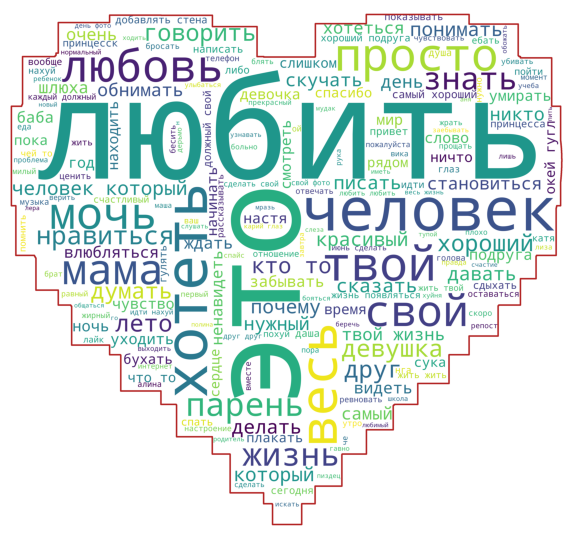

In [240]:
mask = np.array(Image.open('Сердечко.png'))
cloud = WordCloud(width=1000, height=1000, mask = mask,
                  contour_width=20, contour_color='firebrick', 
                  background_color='white', random_state= 765).generate(super_text)

plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Действительно, кажется, что слово __*любить*__ встречается в постах чаще всего. Посмотрим на другие популярные слова

In [148]:
words, counts = list(map(list, np.unique(super_text.split(), return_counts= True))) 

word_counter = []
for i, j in zip(words, counts):
    word_counter.append([i, j])

In [149]:
most_10 = dict(sorted(word_counter, key = lambda x: x[1], reverse=True)[:10])

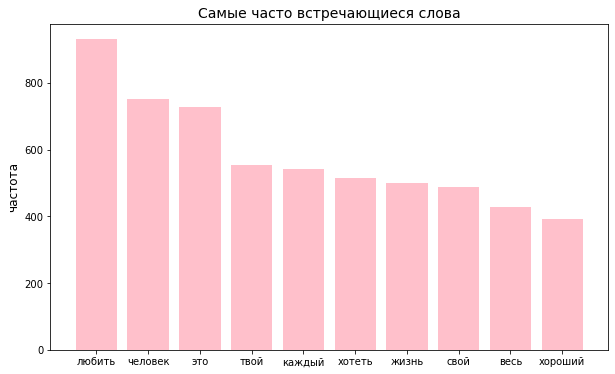

In [150]:
plt.figure(figsize=(10, 6))
plt.bar(most_10.keys(), height=most_10.values(), color = 'pink')
plt.ylabel('частота', fontsize = 12)
plt.title('Самые часто встречающиеся слова', fontsize = 14);

Интересно, почему авторы сообщества dying так часто используют в своих постах слово __*любить*__? Может такие посты набирают больше лайков? Проверим это формально.

In [151]:
def is_loved(string: str):
    string = str(string)
    if 'любить' in string:
        return 1
    else: 
        return 0 

In [152]:
data_no_stopwords['with_love'] = data_no_stopwords.text.apply(is_loved)

loved = data_no_stopwords[data_no_stopwords['with_love'] == 1]
not_loved = data_no_stopwords[data_no_stopwords['with_love'] == 0]

Проверим гипотезу о том, что посты со словом __*любить*__ в среднем набирают больше лайков.

$$
H_0: \mu_{loved} = \mu_{not\_loved}\\
$$
$$
H_1: \mu_{loved} > \mu_{not\_loved}
$$

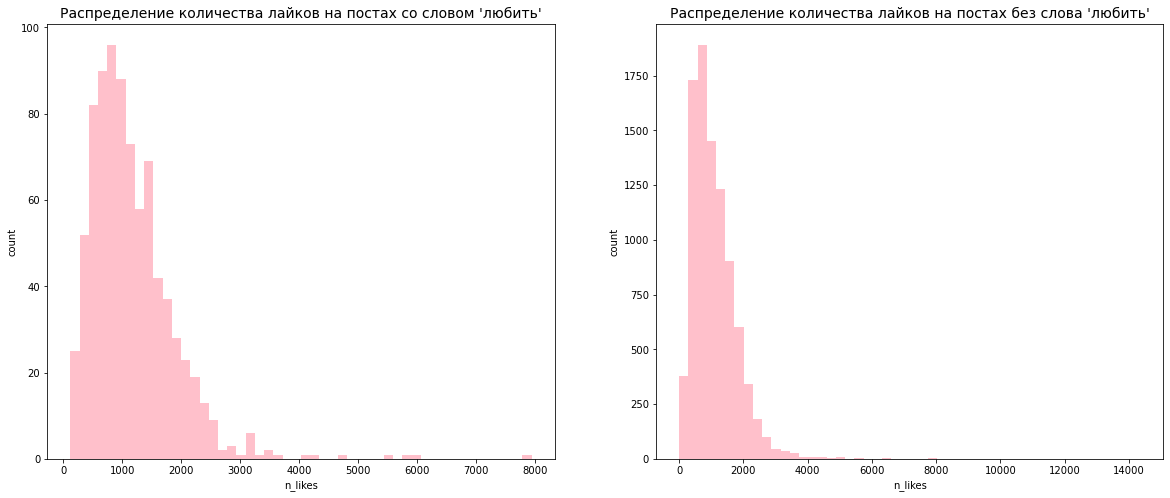

In [153]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (20, 8))

ax[0].hist(loved.n_likes, bins = 50, color = 'pink')
ax[0].set_xlabel('n_likes')
ax[0].set_ylabel('count')
ax[0].set_title("Распределение количества лайков на постах со словом 'любить'" , fontsize = 14)

ax[1].hist(not_loved.n_likes, bins = 50, color = 'pink')
ax[1].set_xlabel('n_likes')
ax[1].set_ylabel('count')
ax[1].set_title("Распределение количества лайков на постах без слова 'любить'" , fontsize = 14);

Среднее количество лайков будет асимптотически нормальным (по ЦПТ), дисперсии количества лайков в каждой группе мы не знаем, поэтому для проверки гипотезы будем использовать тест Уэлчаё

In [154]:
stats.ttest_ind(loved.n_likes, not_loved.n_likes, equal_var= False, alternative= 'greater')

Ttest_indResult(statistic=2.5453997328112554, pvalue=0.005533439306832869)

Полученное p-значение меньше, чем наиболее часто используемые уровни значимости. Нулевая гипотеза отвергается на уровне значимости 0.01, значит мы можем говорить, что посты со словом __*любить*__ в среднем __набирают больше лайков__.

Мы также проверям робастность результатов, заменяя количество лайков на количество репостов. Интуитивно, количество репостов, также как и количество лайков отражает отношение пользователей к посту. Обычно, чем больше лайков репостов, тем больше людей, считают текст в посте отражающим их настроение, значимым для них.

In [155]:
stats.ttest_ind(loved.n_reposts, not_loved.n_reposts, equal_var= False, alternative= 'greater')

Ttest_indResult(statistic=6.3989634170860015, pvalue=1.2021955478567185e-10)

С количеством репостов получили аналогичный результат: Подписчики в среднем больше репостят посты со словом __*любить*__, что может говорить о том, что слово любить в посте приносит постам (и, следовательно группе) большую популярность.

### Теперь посмотрим на маты

Можно предположить, что в группе, где подписчики больше лайкают посты со словом __*любить*__ нет места для негатива и брани. Мы решили изучить этот вопрос, воспользовавшись большим набором матерных слов на русском языке. 

In [156]:
with open('маты.txt', 'r', encoding='utf-8') as file:
    bad_words = set(map(lambda x: x.lower(), file.read().split('\n'))) 

In [157]:
def with_bad_words(string: str):
    words = set(str(string).split())

    if words & bad_words != set():
        return 1
    else:
        return 0

In [158]:
data_no_stopwords['with_bad_words'] = data_no_stopwords.text.apply(with_bad_words)

explicit = data_no_stopwords[data_no_stopwords['with_bad_words'] == 1]
no_explicit = data_no_stopwords[data_no_stopwords['with_bad_words'] == 0]

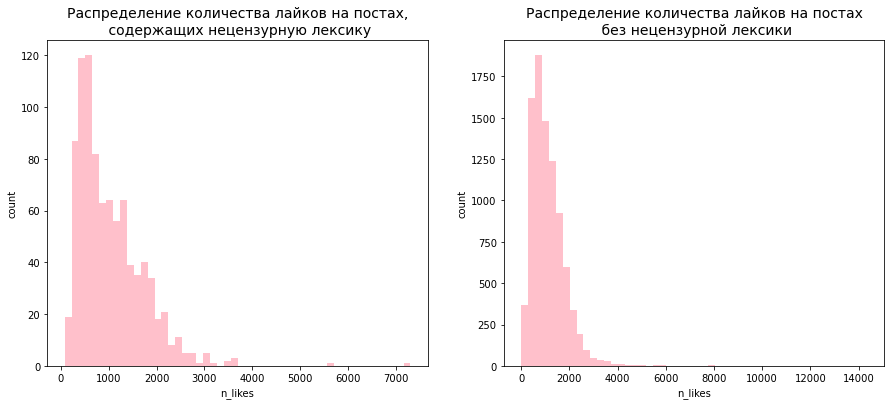

In [159]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (15, 6))

ax[0].hist(explicit.n_likes, bins = 50, color = 'pink')
ax[0].set_xlabel('n_likes')
ax[0].set_ylabel('count')
ax[0].set_title("Распределение количества лайков на постах,\n содержащих нецензурную лексику" , fontsize = 14)

ax[1].hist(no_explicit.n_likes, bins = 50, color = 'pink')
ax[1].set_xlabel('n_likes')
ax[1].set_ylabel('count')
ax[1].set_title("Распределение количества лайков на постах\n без нецензурной лексики" , fontsize = 14);

Судя по выборочным средним, посты, содержащие нецензурную лексику в среднем по выборке набирали меньше лайков, чем посты без такой лексики

In [160]:
explicit.n_likes.mean(), no_explicit.n_likes.mean()

(1027.4424778761063, 1114.1551937113982)

Однако, так ли это на самом деле. Мы статистически проверям гипотезу, о том, что посты с матерными словами в среднем набирают меньше лайков

$$
H_0: \mu_{explicit} = \mu_{no\_explicit}\\
$$
$$
H_1: \mu_{explicit} < \mu_{no\_explicit}
$$

Опять же, мы используем тест Уэлча, так как дисперсии неизвестны.

In [161]:
stats.ttest_ind(explicit.n_likes, no_explicit.n_likes, equal_var= False, alternative= 'less')

Ttest_indResult(statistic=-3.5544903220612625, pvalue=0.00019722443657172926)

Полученное p-значение меньше 0.01, а значит нулевая гипотеза отвергается на уровне значимости 0.1%. Можно довольно уверенно говорить о том, что подписчики группы dying не любят посты с нецензурной лексикой!

### Достанем объединенную табличку с погодой и постами

In [345]:
data_weather_12 = pd.read_csv('https://raw.githubusercontent.com/Pash1i/andan_2023_project/updates/data/data_weather/data_weather_12.csv').drop('Unnamed: 0', axis = 1).dropna()

In [346]:
data_weather_12.date

0       2015-08-17
1       2015-08-17
2       2015-08-17
3       2015-08-17
4       2015-08-17
           ...    
9804    2014-10-30
9805    2014-10-30
9806    2014-10-30
9807    2014-10-30
9808    2014-10-30
Name: date, Length: 9703, dtype: object

In [347]:
data_weather_12.date = data_weather_12.date.apply(datetimer)

Посмотрим, сколько в среднем лайков и репостов набирали посты, опубликованные в один день

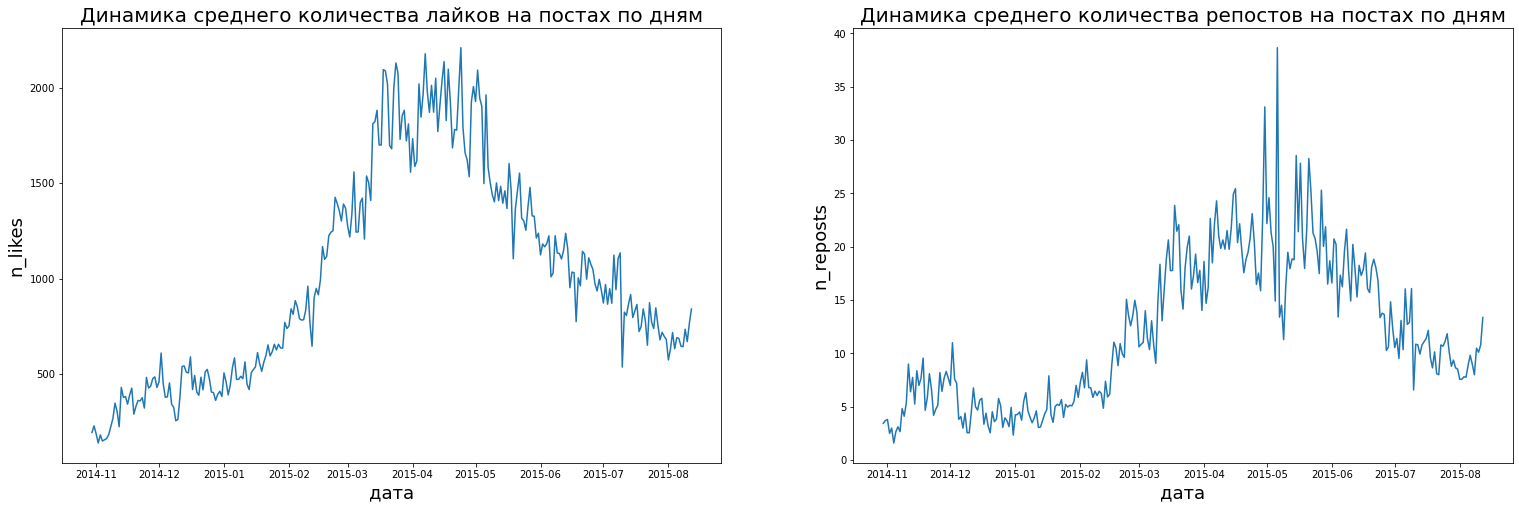

In [348]:
fig, ax = plt.subplots(ncols = 2,figsize = (26,8))

ax[0].plot(data_no_stopwords.groupby(by = 'date').n_likes.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_likes.mean().values[:287])
ax[0].set_xlabel('дата', fontsize = 18)
ax[0].set_ylabel('n_likes', fontsize = 18)
ax[0].set_title('Динамика среднего количества лайков на постах по дням', fontsize = 20); 

ax[1].plot(data_no_stopwords.groupby(by = 'date').n_reposts.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_reposts.mean().values[:287])
ax[1].set_xlabel('дата', fontsize = 18)
ax[1].set_ylabel('n_reposts', fontsize = 18)
ax[1].set_title('Динамика среднего количества репостов на постах по дням', fontsize = 20);

Я убрал последние несколько дней, так как из-за того, что паблик не активен с августа 2015-года, последние опубликованные посты набрали за 8 лет очень много лайков и, по-факту, являются выбросом и мешают анализу 

### Построим модель, которая предсказывает количество лайков на посте на основе погоды в день публикации.

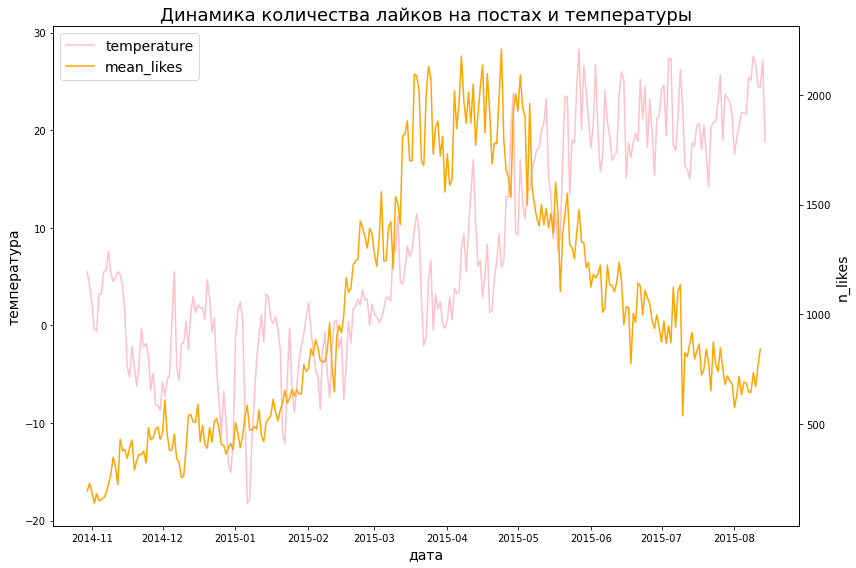

In [349]:
fig,ax1 = plt.subplots(figsize = (12,8))

weather = ax1.plot(data_weather_12.groupby('date').mean()['T'].index[:287], data_weather_12.groupby('date').mean()['T'].values[:287], color ='pink', label = 'temperature')
ax1.set_ylabel('температура', fontsize = 14)
ax1.set_xlabel('дата', fontsize = 14)
ax1.set_title('Динамика количества лайков на постах и температуры', fontsize = 18)
ax2 = ax1.twinx()
likes = ax2.plot(data_no_stopwords.groupby(by = 'date').n_likes.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_likes.mean().values[:287], color = 'orange', label = 'mean_likes')
ax2.set_ylabel('n_likes', fontsize = 14)
fig.tight_layout()

lns = weather + likes
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc =0, fontsize = 14);

Судя по графику, какой-то определенной явной зависимости не наблюдается. Иногда между температурой и количеством лайков есть положительная связь, а иногда - отрицательная.

Мы хотим посмотреть, что лучше предсказывает количество лайков на постах в паблике __*dying:*__ содержание поста или погода за окном в тот день. Зачем? Нам интересно, насколько на самом деле важно содержание постов в паблике. Нам кажется, что в сообществах такого типа количество лайков далеко не всегда зависит от того, что публикуется администраторами.

Мы решили, проверить, а вдруг, можно довольно точно предсказывать популярность постов (измеренную в количестве лайков) на основе погодных условий в тот день.

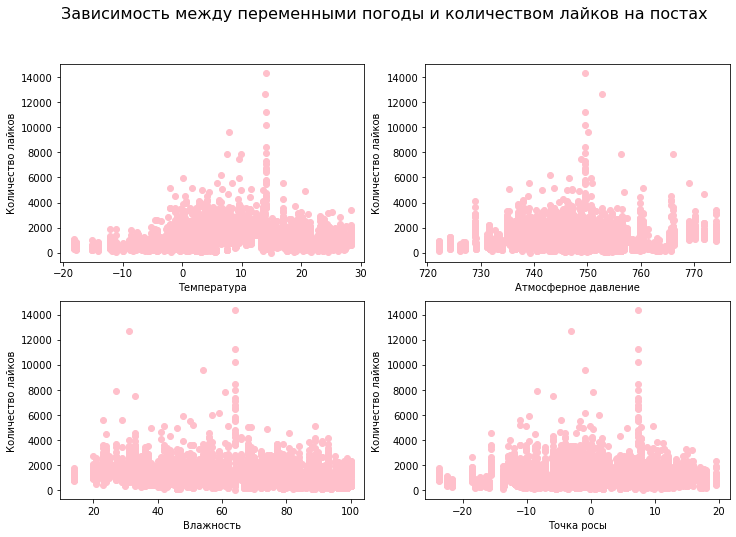

In [350]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

fig.suptitle('Зависимость между переменными погоды и количеством лайков на постах', fontsize = 16)
ax[0,0].scatter(data_weather_12['T'], data_weather_12['n_likes'], color = 'pink')
ax[0,0].set_xlabel('Температура')
ax[0,0].set_ylabel('Количество лайков')

ax[0,1].scatter(data_weather_12['Po'], data_weather_12['n_likes'], color = 'pink')
ax[0,1].set_xlabel('Атмосферное давление')
ax[0,1].set_ylabel('Количество лайков')

ax[1,0].scatter(data_weather_12['U'], data_weather_12['n_likes'], color = 'pink')
ax[1,0].set_xlabel('Влажность')
ax[1,0].set_ylabel('Количество лайков')

ax[1,1].scatter(data_weather_12['Td'], data_weather_12['n_likes'], color = 'pink');
ax[1,1].set_xlabel('Точка росы')
ax[1,1].set_ylabel('Количество лайков');

Судя по точечным диаграммам какой-либо значимой взаимосвязи между погодными условиями нет. Однако, мы хотим точно в этом убедиться. Будем строить регрессию!

In [351]:
weather_reg_12 = data_weather_12[['T', 'Po', 'U', 'DD', 'Ff', 'N', 'VV', 'Td', 'n_likes']]

Подготовим данные. Сначала посмотрим на порядковые признаки.

In [352]:
weather_reg_12.sample(3)

,T,Po,U,DD,Ff,N,VV,Td,n_likes
4169,14.0,751.7,31.0,"Ветер, дующий с севера",2.0,4.0,10.0,-2.9,1502
1911,24.6,750.6,40.0,"Ветер, дующий с севера",2.0,2.0,10.0,10.1,657
556,20.5,753.4,47.0,"Ветер, дующий с западо-юго-запада",1.0,6.0,10.0,8.9,903


In [353]:
np.unique(weather_reg_12.VV)

array([ 0.5,  1. ,  2. ,  4. , 10. ])

Упорядочим горизонтальную дальность видимости (VV)

In [354]:
mapper = {0.5: 0, 1: 1, 2:2, 4:3, 10: 4}

In [355]:
weather_reg_12.VV = weather_reg_12.VV.apply(lambda x:mapper[x])

In [356]:
np.unique(weather_reg_12.VV)

array([0, 1, 2, 3, 4], dtype=int64)

In [357]:
np.unique(weather_reg_12.N)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

In [358]:
np.unique(weather_reg_12.Ff)

array([0., 1., 2., 3., 4., 5.])

Категориальный признак направление ветра (DD) преобразуем с помощью OneHot-кодирования

In [359]:
weather_reg_12 = pd.get_dummies(weather_reg_12, columns=["DD"], drop_first=True)

In [360]:
weather_reg_12.sample(3)

,T,Po,U,Ff,N,VV,Td,n_likes,"DD_Ветер, дующий с востоко-северо-востока","DD_Ветер, дующий с востоко-юго-востока",...,"DD_Ветер, дующий с северо-востока","DD_Ветер, дующий с северо-запада","DD_Ветер, дующий с северо-северо-востока","DD_Ветер, дующий с северо-северо-запада","DD_Ветер, дующий с юга","DD_Ветер, дующий с юго-востока","DD_Ветер, дующий с юго-запада","DD_Ветер, дующий с юго-юго-востока","DD_Ветер, дующий с юго-юго-запада","DD_Штиль, безветрие"
3978,19.9,750.7,27.0,3.0,5.0,4,0.4,1284,0,0,...,0,0,0,0,0,0,0,0,0,0
9315,0.4,750.1,98.0,1.0,8.0,2,0.1,814,0,0,...,0,0,0,0,0,0,0,1,0,0
849,23.7,740.6,67.0,1.0,8.0,4,17.3,969,0,0,...,0,0,0,0,0,0,0,1,0,0


In [361]:
X = weather_reg_12.drop('n_likes', axis = 1)
y = weather_reg_12['n_likes']

Разделим выборку на тренировочную и тестовую

In [364]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=875)

Стандартизируем количественные признаки

In [372]:
scaler = StandardScaler()
X_train[['T', 'Po', 'U', 'Td']] = scaler.fit_transform(X_train[['T', 'Po', 'U', 'Td']])
X_test[['T', 'Po', 'U', 'Td']] = scaler.transform(X_test[['T', 'Po', 'U', 'Td']])

Обучим простую линейную модель

In [399]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [400]:
mean_squared_error(y_train, linear.predict(X_train))

443580.1582391248

In [401]:
mean_squared_error(y_test, linear.predict(X_test))

6331217462.755348

Получили ошибку невообразимых размеров на тесте! Модель явно переобучилась Как так вышло? Посмотрим, что выдает предикт.

In [402]:
linear.predict(X_test)

array([-61133.02538014, -62929.47680697, -76874.78293142, ...,
       -66009.61580961, -60234.96324075, -95283.5556426 ])

Отрицательное количество лайков... Такого не может быть в действительности.

А на трейне

In [530]:
linear.predict(X_train)

array([ 543.36470855, 1596.65603335,  852.22034617, ...,  631.53910282,
        999.99648503, 1070.37342765])

Коэффициенты модели:

In [531]:
linear.coef_

array([-888.61065592,  -26.27052246, -802.33736858,  179.32482195,
         46.33541885, -131.16316782,  697.86185991, -115.02263715,
        -95.54915683, -257.3424135 , -188.11271316, -310.46650013,
       -228.03734056,   68.87168054, -281.90382134, -275.64018416,
       -368.15777366, -338.9162865 ,   90.71195506, -143.34026716,
       -119.11051738, -133.45717116,  184.40740209])

Добавим L2 регуляризацию, чтобы побороться с переобучением. Регуляризовать придется очень сильно, так как хотим приблизить ошибку на тесте к ошибке на трейне (ну и желательно, чтобы прогнозы были положительными). Ручками перебрав несколько вариантов параметра регуляризации $\alpha$ мы решили остановиться на параметре регуляризации равном 80000. Благодаря нему, был пройден 'ментальный' трешолд -- ошибка на тесте стала меньше 1 миллиона. Однако ошибка на трейне выросла на сто тысяч.

In [553]:
ridge = Ridge(80000)
ridge.fit(X_train, y_train)

Ridge(alpha=80000)

In [539]:
mean_squared_error(y_train, ridge.predict(X_train))

517185.77240025654

In [540]:
mean_squared_error(y_test, ridge.predict(X_test))

956451.3493140042

In [551]:
np.sum(ridge.predict(X_test) > 0) , np.sum(ridge.predict(X_test) < 0)

(1697, 244)

как минимум большинство предсказаний теперь положительны

Попробуем регуляризовать с помощью L1-регуляризации.

In [598]:
lasso = Lasso(1500)
lasso.fit(X_train, y_train)

Lasso(alpha=1500)

In [599]:
mean_squared_error(y_train, lasso.predict(X_train))

532925.4706294137

In [600]:
mean_squared_error(y_test, lasso.predict(X_test))

613354.9291692859

In [603]:
lasso.predict(X_test) # пример пре-регуляризации -- константная модель

array([1109.14841536, 1109.14841536, 1109.14841536, ..., 1109.14841536,
       1109.14841536, 1109.14841536])

In [604]:
lasso.coef_

array([ 0.,  0., -0.,  0., -0.,  0., -0., -0.,  0., -0.,  0., -0.,  0.,
        0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0.])

Перебрав разные параметры регуляризации, мы пришли к выводу, что лассо модель не сможет нам помочь. Если брать небольшой параметр $\alpha$, то ошибка на тесте остается огромной. Но если взять слишком большое $\alpha$, большинство коэффициентов занулится, модель превратится в константную, предиктить будет только интерсепт.

Таким образом, лучшее, что нам получилось достать из линейных моделей -- Ridge с очень большой регуляризацией.

Попробуем залезть в болото нелинейных моделей. Обучим Решающее дерево, подобрав оптимальные параметры с помощью кросс-валидации.

In [632]:
depth = [None, 1, 2, 3, 5, 7, 10, 13, 17, 20, 25, 30] # это максимальная глубина дерева - сколько может быть 'подветок'
min_samples_leaf = [2, 3, 5, 8, 10, 13, 15, 18, 20, 25, 30] # минимальное количество наблюдений, чтобы сделалась листовая вершина
min_samples_split = [2, 3, 5, 8, 10, 13, 15, 18, 20, 25, 30] # миимальное количество наблюдений, чтобы из вершины отвести две новые

все так же будем оценивать модель на mse, чтобы можно было сравнить с регрессиями.

In [636]:
gridsearcher = GridSearchCV(estimator = DecisionTreeRegressor(),
                            param_grid= {'max_depth': depth, 'min_samples_leaf': min_samples_leaf, 'min_samples_split': min_samples_split},
                           scoring = 'neg_mean_squared_error', cv = 3)

In [637]:
gridsearcher.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 1, 2, 3, 5, 7, 10, 13, 17, 20, 25,
                                       30],
                         'min_samples_leaf': [2, 3, 5, 8, 10, 13, 15, 18, 20,
                                              25, 30],
                         'min_samples_split': [2, 3, 5, 8, 10, 13, 15, 18, 20,
                                               25, 30]},
             scoring='neg_mean_squared_error')

Нашли лучшую модель:

In [638]:
gridsearcher.best_estimator_

DecisionTreeRegressor(max_depth=17, min_samples_leaf=2, min_samples_split=15)

In [643]:
pd.DataFrame(gridsearcher.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009151,0.007943,0.003411,0.003507,None,2,2,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-204071.102326,-240041.462446,-250170.944577,-231427.836449,19781.216317,21
1,0.014978,0.007705,0.001328,0.000939,None,2,3,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-204096.062391,-240041.462446,-250170.944577,-231436.156471,19769.710170,25
2,0.010448,0.007388,0.000000,0.000000,None,2,5,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-204096.062391,-240041.462446,-250170.944577,-231436.156471,19769.710170,25
3,0.010459,0.007396,0.000000,0.000000,None,2,8,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-204071.102326,-240045.081626,-250149.250637,-231421.811530,19774.891965,16
4,0.005207,0.007364,0.005208,0.007365,None,2,10,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",-204094.602330,-240014.032916,-250149.250637,-231419.295294,19759.551171,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447,0.010834,0.007675,0.000000,0.000000,30,30,15,"{'max_depth': 30, 'min_samples_leaf': 30, 'min...",-257307.787191,-276149.011696,-266348.562255,-266601.787048,7693.981514,760
1448,0.005211,0.007370,0.005205,0.007361,30,30,18,"{'max_depth': 30, 'min_samples_leaf': 30, 'min...",-257307.787191,-276149.011696,-266348.562255,-266601.787048,7693.981514,760
1449,0.005211,0.007370,0.000000,0.000000,30,30,20,"{'max_depth': 30, 'min_samples_leaf': 30, 'min...",-257307.787191,-276149.011696,-266348.562255,-266601.787048,7693.981514,760
1450,0.010414,0.007364,0.000000,0.000000,30,30,25,"{'max_depth': 30, 'min_samples_leaf': 30, 'min...",-257307.787191,-276149.011696,-266348.562255,-266601.787048,7693.981514,760


In [644]:
mean_squared_error(y_test, gridsearcher.predict(X_test))

827343.249656238

In [645]:
mean_squared_error(y_train, gridsearcher.predict(X_train)) 

211760.9042149272

Это лучше, чем базовая модель линейной регрессии, однако, все еще есть сильное переобучение, так как ошибка на трейне сильно меньше, чем на тесте.

### Теперь построим модель, предсказывающую количество лайков на основе текста!

In [652]:
data_weather_12.text

0                               хотеть видеть каждый день
1                  жить жить твой жизнь появляться полина
2                                          скучать наташа
3                         давать бог каждый сердце искать
4       арина милашка арина бандитка арина псих арина ...
                              ...                        
9804                     земля носить гравитация тыры пыр
9805                                   сохранять нежность
9806     лицо прыщик комплексовать подумать вместо сиська
9807    милый пара видеть держаться рука держать рука ...
9808    кукла игрушка девочка который мочь рожа давать...
Name: text, Length: 9703, dtype: object

Чтобы использовать алгоритмы машинного обучения, надо векторизовать тексты. Наши тексты уже лемматизированы, поэтому токенизация не нужна. Будем считать токеном одно слово. Векторизация:

In [665]:
cnt_vec = CountVectorizer()
texts = cnt_vec.fit_transform(data_weather_12.text)
texts 

<9703x6546 sparse matrix of type '<class 'numpy.int64'>'
	with 52070 stored elements in Compressed Sparse Row format>

In [664]:
Получили разреженную матрицу размера 9703 (наблюдений) на 6546 (уникальных токенов). 

<9703x6546 sparse matrix of type '<class 'numpy.int64'>'
	with 52070 stored elements in Compressed Sparse Row format>

Обучим линейную регресиию!

In [673]:
X_train, X_test, y_train, y_test = train_test_split(texts, data_weather_12.n_likes, test_size=0.2, random_state=235)

In [675]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [676]:
mean_squared_error(y_test, model.predict(X_test))

1430237.9313888426

In [677]:
mean_squared_error(y_train, model.predict(X_train))

223607.26279482743

Получили неплохие ошибки, однако есть перобучение! Сделаем L2-регуляризацию

In [691]:
ridge = Ridge(5)
ridge.fit(X_train, y_train)

Ridge(alpha=5)

Подберем параметр регуляризации по тесту.

In [699]:
alphas = np.linspace(0.1, 50, 100)

In [703]:
mse = []
for alpha in tqdm(alphas):
    ridge = Ridge(alpha)
    ridge.fit(X_train, y_train)
    mse.append(mean_squared_error(y_test, ridge.predict(X_test)))

100%|██████████| 100/100 [00:02<00:00, 45.41it/s]


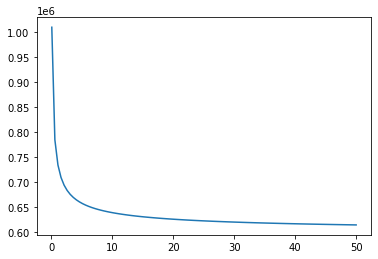

In [705]:
plt.plot(alphas, mse)

In [707]:
ridge = Ridge(40)
ridge.fit(X_train, y_train)

Ridge(alpha=40)

In [708]:
mean_squared_error(y_train, ridge.predict(X_train))

438473.0974946264

In [709]:
mean_squared_error(y_test, ridge.predict(X_test))

616613.5530462897

Получили результат лучше, чем для моделей, обученных на данных о погоде, с точки зрения трейдоффа между переобучением и величиной ошибки на трейне. Но и в принципе, эти результаты лучше, чем для 'погодной модели', если смотреть с позиции величины среднеквадратичныз ошибок.